# Cleaning ABES extraction 

Ce notebook permet de vérifier l'extraction de données réalisée par l'ABES et d'enlever les notices potentiellement mal formattées (du fait de correspondance entre les métadonnées de la notice et le type de séparateur choisi par exemple).
Une étape de mise à plat des chaines d'indexation est également réalisée ainsi qu'une première exploration des concepts RAMEAU et labels TEF (issus de la classification décimale de DEWEY) sous forme de visualisation graphique (barplots et wordcloud)

MAJ - 03/05/2023 (Aurélie Thébault - EcoStats)

MAJ 16/09/2023:
L'étude approfondie des Chaines d'indexation et concepts RAMEAU a montré que les concepts RAMEAU présents dans le fichier de données extrait du SUDOC n'étaient pas limités au concepts "Noms Communs" (Td). Les chaines d'indexation contiennent en effet également des concepts "Forme/Genre" (i.e. Tf) ainsi que des concepts de collectivité. 
Nous avons décidé de ne garder que les concepts appartenant aux types Td et Tf et d'enlever tous les autres. 

# Set project

In [41]:
# Import packages and useful functions

from utils_metrics import *
from utils_project import *
from utils_visualization import *

# Import data

In [42]:
# Import des données (premiere version, avec DEWEY)
filepath = "extraction/export.dsv"
working_data_filename = "working_data.csv"
export_data_filename = "data_to_check.csv"
encoding = "latin-1"  # (useful only on first extraction)
data = import_data(filepath, encoding)
filename = filepath.split('/')[-1].split('.')[0]
merge_with_dewey = True
clean_concepts = True

In [43]:
# Import des données
filepath = "extraction/export_sans_dewey.dsv"
working_data_filename = "working_data_sans_dewey.pkl"
export_data_filename = "data_to_check_sans_dewey.pkl"
data = import_data(filepath)#, encoding)
filename = filepath.split('/')[-1].split('.')[0]
merge_with_dewey = False

In [44]:
# RAMEAU concepts files
rameau_file_td = "extraction/liste_concepts_rameau_sans_vedetteConstruites.csv"
rameau_file_tf = "extraction/Tf8_Forme-genre_Rameau_juin_2023.csv"

In [45]:
if clean_concepts:
    ram_td = pd.read_csv(os.path.join(data_path, rameau_file_td), encoding="latin-1")
    ram_tf = pd.read_csv(os.path.join(data_path, rameau_file_tf), encoding="utf-8", sep=";")
    ram_tf = ram_tf.rename(columns={"A001_AS":"PPN", "A008_AS":'type', 'A003_AS': "URI", "A280.A280Sa_AS":"NOM"})
    ram_tf = ram_tf.dropna()

    # Correction de tous les problèmes liés aux @ 
    ram_td["NOM"] = ram_td["NOM"].apply(lambda x: re.sub(r" [?]", "", re.sub(r"^[?]", "", x)))
    ram_tf["NOM"] = ram_tf["NOM"].apply(lambda x: re.sub(r" [?]", "", re.sub(r"^[?]", "", x)))
    ram_td["NOM"] = ram_td["NOM"].apply(lambda x: re.sub(r"[\\],", ",", x))
    ram_tf["NOM"] = ram_tf["NOM"].apply(lambda x: re.sub(r"[\\],", ",", x))
    
    # Création des URIs pour les TD
    BASE_URI = 'https://www.idref.fr/'
    ram_td["URI"] = ram_td["PPN"].apply(lambda x: BASE_URI + x)
    cols = ["PPN", "NOM", "URI"]

    # Concatenate Tf and Td concepts 
    authorized_concepts = pd.concat([ram_td["NOM"],  ram_tf["NOM"]]).dropna().to_list()
    print(f"{len(set(authorized_concepts))} authorized concepts among Td and tf")

103021 authorized concepts among Td and tf


In [46]:
# Format and save concept files
authorized_concepts_df = pd.DataFrame(pd.concat([ram_td[cols],  ram_tf[cols]]), columns = cols)
authorized_concepts_df.to_csv(os.path.join(data_path, "rameau_Tf_Td.csv"))

In [47]:
# Clean file
df = checkDataFormat(data)
df.check_format()
df.sort_notices(
    save_file=working_data_filename,
    export_name=export_data_filename)

There are 169702 in this file with till 11 columns
There are 38 badly formatted notices
There are 169663 well formatted rows


 ==> Working dataset has 169663 notices
Cleaned file contains 169663 notices and  5 columns
Need to check 38 notices extractions
Save working data as working_data_sans_dewey.pkl
Save data to check data as data_to_check_sans_dewey.pkl


In [48]:
# Load working data
if working_data_filename.endswith(("pkl", "pickle")):
    df = pd.read_pickle(os.path.join(data_path, working_data_filename))
elif working_data_filename.endswith('csv'):
    df = pd.read_csv(os.path.join(data_path, working_data_filename), index_col=0)
print(f"Data loaded :", df.shape)

Data loaded : (169663, 5)


In [49]:
df.head(5)

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830


In [50]:
# Ajout d'une colonne description (Titre + resumé)
df.loc[:, "DESCR"] = df.loc[:, 'TITRE'] + ' ' + df.loc[:, 'RESUME']

# Check concepts

In [56]:
def check_sudoc_indexation(chain, authorized_concepts):
    pattern = r';\s*(?![^()]*\))'
    concepts = re.split(pattern, chain)
    rameau = []
    removed = []
    check_concepts = []
    check_subconcepts = []
    # Explore 606 block
    for x in concepts :
        if re.sub('  ', ' ', x) in authorized_concepts:
            check_concepts.append(x)

        elif " -- " in x:
            sub_x = x.split(" -- ")
            for xx in sub_x:
                if xx in authorized_concepts:
                    check_subconcepts.append(xx)
                elif re.sub('  ', ' ', xx) in authorized_concepts:
                    check_subconcepts.append(xx)
                else:
                    removed.append(xx)
            # Rebuild indexation chains
            chained = " -- ".join(check_subconcepts)
            check_concepts.append(chained)
            check_subconcepts = []

        else:
            removed.append(x)

    # Rebuild indexation list
    if check_concepts:
        rameau = ";".join(check_concepts)
    else:
        rameau = str()
    
    # Save list of retrieved concepts
    removed_concepts = list(set(removed))
    with open(os.path.join(data_path, "list_of_retrieved_sudoc_concepts.txt"), "w") as output:
        output.write(str(removed_concepts))
            
    return rameau

In [57]:
# Keep only authorized concepts (Td and Tf) - takes long time (~ 3min)
df["RAMEAU_CHECKED"] = df["RAMEAU"].apply(lambda x: check_sudoc_indexation(x, authorized_concepts))
df.head(5)

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,Science-fiction américaine -- Traductions fran...


In [58]:
# Check on 2 examples
ppn = "264745469"
print("PPN :", ppn)
print("avant nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU"].to_list())
print("après nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU_CHECKED"].to_list())

ppn = "266381804"
print("\nPPN :", ppn)
print("avant nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU"].to_list())
print("après nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU_CHECKED"].to_list())

ppn = "178815225"
print("\nPPN :", ppn)
print("avant nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU"].to_list())
print("après nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU_CHECKED"].to_list())

ppn = "163560064"
print("\nPPN :", ppn)
print("avant nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU"].to_list())
print("après nettoyage: ", df.loc[df["PPN"] == ppn, "RAMEAU_CHECKED"].to_list())

PPN : 264745469
avant nettoyage:  ['Administration communale -- Chambon;Développement rural -- Chambon;Paysage rural -- Chambon']
après nettoyage:  ['Administration communale;Développement rural;Paysage rural']

PPN : 266381804
avant nettoyage:  ['Cuisine (chevreuil ; viande)']
après nettoyage:  ['Cuisine (chevreuil ; viande)']

PPN : 178815225
avant nettoyage:  ['Le  Petit Chaperon rouge (conte)']
après nettoyage:  ['Le  Petit Chaperon rouge (conte)']

PPN : 163560064
avant nettoyage:  ["Art -- Thèmes, motifs;La  Tour de Babel (épisode biblique) -- Dans l'art"]
après nettoyage:  ["Art -- Thèmes, motifs;La  Tour de Babel (épisode biblique) -- Dans l'art"]


# Explore RAMEAU

In [59]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU => i.e chaines d'indexation
df["presence_chaine_indexation"] = df["RAMEAU_CHECKED"].apply(lambda x: True if re.search(' -- ', x) else False)
n_chaine_index = df["presence_chaine_indexation"].sum()
print(f"Le jeu de données contient {n_chaine_index} notices avec des chaines d'indexation")

Le jeu de données contient 73727 notices avec des chaines d'indexation


In [60]:
df.loc[df["presence_chaine_indexation"] == True, ["PPN", "RAMEAU", "RAMEAU_CHECKED"]]

,PPN,RAMEAU,RAMEAU_CHECKED
4,000026352,Science-fiction américaine -- Traductions fran...,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...,Attachement;Mères et nourrissons;Personnalité ...
11,000045535,Hôpitaux -- Sociologie,Hôpitaux -- Sociologie
12,000049719,Civilisation -- Histoire,Civilisation -- Histoire
...,...,...,...
169644,268995249,Physique -- Dans l'art;Sciences et arts,Physique -- Dans l'art;Sciences et arts
169647,268995966,Neurosciences;Violences sexuelles -- Lutte con...,Neurosciences;Violences sexuelles -- Lutte con...
169656,268998604,Activités dirigées;Biscuits;Cookies;Cuisine;Gâ...,Activités dirigées;Biscuits;Cookies;Cuisine;Gâ...
169657,268998663,Catastrophes -- Aspect psychologique;Catastrop...,Catastrophes;Catastrophes -- Aspect social;Fra...


In [61]:
# Check if notices have no RAMEAU concept after cleaning
notice_without_indexation = df[df["RAMEAU_CHECKED"] == ""]
print(f"Il y a {notice_without_indexation.shape[0]} notices sans indexation (concepts non présent dans Tf ou Td)")
notice_without_indexation.to_csv(os.path.join(data_path, "notices_without_RAMEAU_index.csv"))
notice_without_indexation.head(3)

Il y a 61 notices sans indexation (concepts non présent dans Tf ou Td)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation
1600,003414051,"Méthodo CM2-6e, fichier d'activités transdisci...",Fichier d'activités transdisciplinaires pour p...,Matériel didactique,,"Méthodo CM2-6e, fichier d'activités transdisci...",,False
11270,082865272,Le Code Da Vinci décrypté : le guide non autorisé,Prenez le Pouvoir ! N'attendez pas que les mir...,Christianisme et ésotérisme,813.6 critique,Le Code Da Vinci décrypté : le guide non autor...,,False
13009,094552746,Fatalités économiques,Résumés des articles en français et en anglais,Économie politique et politique,,Fatalités économiques Résumés des articles en ...,,False


In [62]:
# Retrieval of notices without any indexation
df = df[df["RAMEAU_CHECKED"] != ""]
print(f"Après retrait des notices sans indexation Tf ou Td, il reste {df.shape[0]} notices")

Après retrait des notices sans indexation Tf ou Td, il reste 169602 notices


In [63]:
# Extraction des chaines d'indexation
rx_semicolumn = re.compile(r";(?![^(]*\))")
df["rameau_chaines_index"] = df["RAMEAU_CHECKED"].apply(lambda x: rx_semicolumn.split(x))
print(df.loc[1:10, "rameau_chaines_index"])

1         [Complexe de castration, Psychanalyse, Rêves]
2                                             [Culture]
3                                      [Structuralisme]
4     [Science-fiction américaine -- Traductions fra...
5                                        [Photographie]
6     [Agglomérations urbaines, Aménagement du terri...
7                   [Tarots (cartes à jouer) -- Contes]
8     [Allégorie de la caverne, Différences entre se...
9     [Attachement, Mères et nourrissons, Personnali...
10               [Philosophes, Philosophie et sciences]
Name: rameau_chaines_index, dtype: object


In [64]:
# Nombre de de notices d'autorité différentes (y compris pré-construites)
# ex d'autorité preconstruite : Science-fiction américaine -- Traductions française
from itertools import chain
rameau_chaine_index = df["rameau_chaines_index"].tolist()
rameau_list_chaines_index = list(chain(*rameau_chaine_index))
print(f"{len(rameau_list_chaines_index)} chaines d'indexation rameau, dont {len(set(rameau_list_chaines_index))} différentes")

376418 chaines d'indexation rameau, dont 73985 différentes


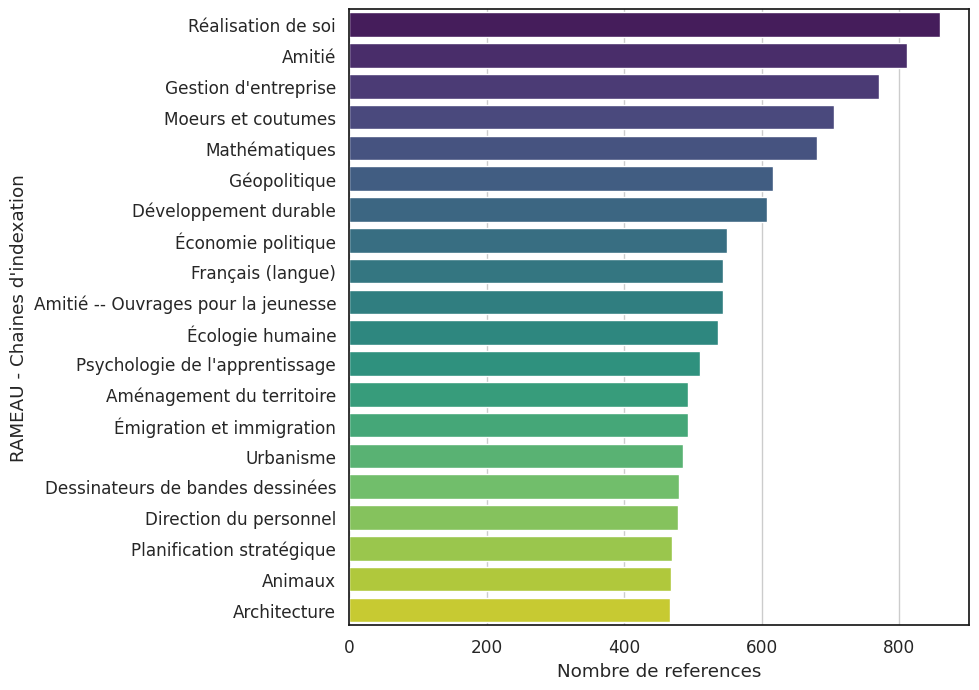

In [65]:
plot_barplot_of_tags(
    tags_list=rameau_list_chaines_index,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Chaines d'indexation",
    figsave=str(filename + "_" + 'barplot_Rameau_ChainesIndex_after_cleaning.png'),
    figsize=(8, 8))

In [66]:
# Mettre à plat TOUS les mots clé
pattern = r';\s*(?![^()]*\))| -- '
df["rameau_concepts"] = df["RAMEAU_CHECKED"].apply(lambda x: re.split(pattern, x))
df.loc[1:20, ["RAMEAU", "RAMEAU_CHECKED","rameau_concepts"]]

,RAMEAU,RAMEAU_CHECKED,rameau_concepts
1,Complexe de castration;Psychanalyse;Rêves,Complexe de castration;Psychanalyse;Rêves,"[Complexe de castration, Psychanalyse, Rêves]"
2,Culture,Culture,[Culture]
3,Structuralisme,Structuralisme,[Structuralisme]
4,Science-fiction américaine -- Traductions fran...,Science-fiction américaine -- Traductions fran...,"[Science-fiction américaine, Traductions franç..."
5,Photographie,Photographie,[Photographie]
6,Agglomérations urbaines;Aménagement du territo...,Agglomérations urbaines;Aménagement du territo...,"[Agglomérations urbaines, Aménagement du terri..."
7,Tarots (cartes à jouer) -- Contes,Tarots (cartes à jouer) -- Contes,"[Tarots (cartes à jouer), Contes]"
8,Allégorie de la caverne;Différences entre sexe...,Allégorie de la caverne;Différences entre sexe...,"[Allégorie de la caverne, Différences entre se..."
9,Attachement;Mères et nourrissons;Personnalité ...,Attachement;Mères et nourrissons;Personnalité ...,"[Attachement, Mères et nourrissons, Personnali..."
10,Philosophes;Philosophie et sciences,Philosophes;Philosophie et sciences,"[Philosophes, Philosophie et sciences]"


In [67]:
keywords = flatten(df['rameau_concepts'])
print(f"Le dataset contient {len(set(keywords))} concepts RAMEAU differents")

Le dataset contient 26014 concepts RAMEAU differents


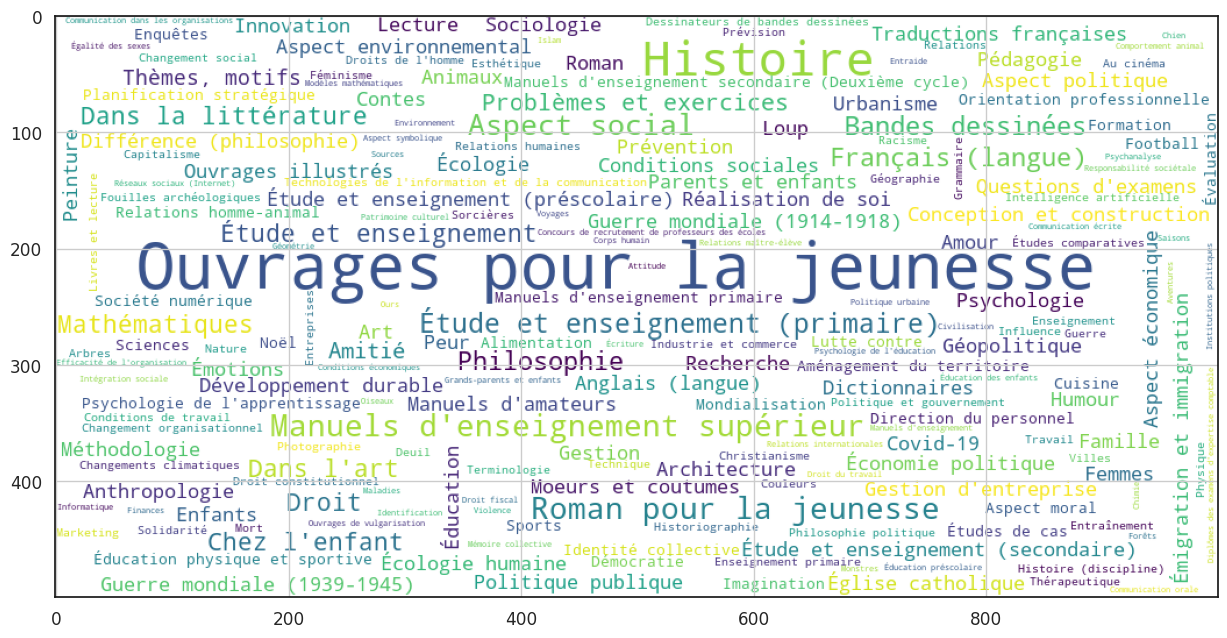

In [68]:
# Show main vedettes
plot_wordcloud(keywords, save_file=str(filename + "_" + "rameau_concepts_wordcloud_after_Cleaning.png"))

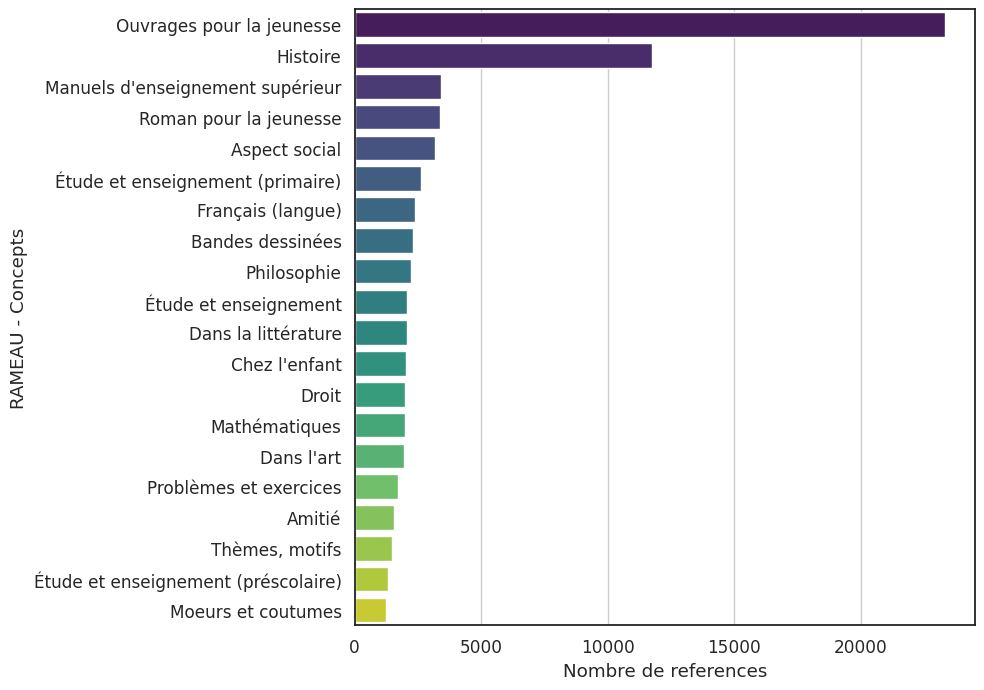

In [69]:
plot_barplot_of_tags(
    tags_list=keywords,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Concepts",
    figsave=str(filename + "_" + 'barplot_Rameau_concepts_after_cleaning.png'),
    figsize=(8, 8))

### Remove vedettes

In [70]:
list_vedettes = ["Ouvrages pour la jeunesse", "Roman pour la jeunesse"]
colonne = "rameau_concepts"
temp = removeVedettes(df, colonne, list_vedettes)
temp.remove_vedette()

Nbre de notices contenant le concept 'Ouvrages pour la jeunesse' : 13293
Nbre de notices contenant le concept 'Roman pour la jeunesse' : 1949
Les vedettes de ['Ouvrages pour la jeunesse', 'Roman pour la jeunesse'] ont été retirées du dataset
Le dataset contient maintenant 154447 notices


### Check cleaned file

In [71]:
# Dataset final
cleaned_df = temp.df_reduced
cleaned_df.shape

(154447, 10)

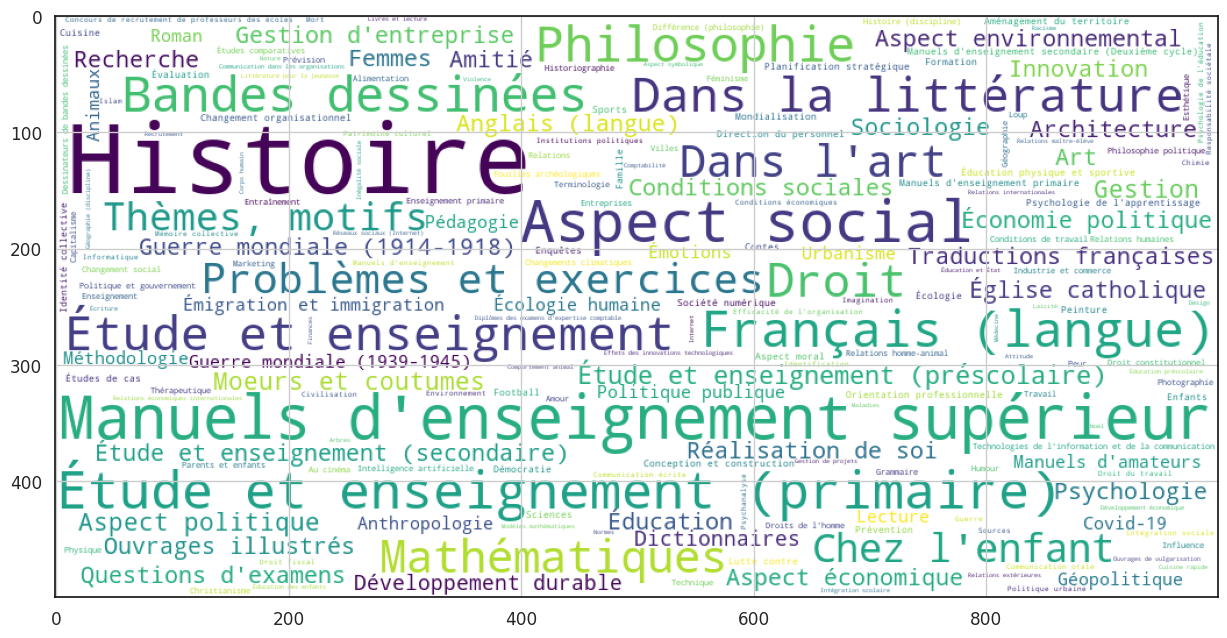

In [72]:
# Show main vedettes
keywords2 = flatten(cleaned_df['rameau_concepts'])
plot_wordcloud(keywords2, save_file=str(filename + "_" + "rameau_concepts_wordcloud_after_cleaning_cleaned.png"))

In [73]:
print(f"{len(keywords2)} concepts rameau, dont {len(set(keywords2))} différents")

449707 concepts rameau, dont 25739 différents


In [74]:
# Nombre de de notices d'autorité différentes (y compris pré-construites)
# ex d'autorité preconstruite : Science-fiction américaine -- Traductions française
from itertools import chain
rameau_chaine_index = cleaned_df["rameau_chaines_index"].tolist()
rameau_list_chaines_index = list(chain(*rameau_chaine_index))
print(f"{len(rameau_list_chaines_index)} chaines d'indexation rameau, dont {len(set(rameau_list_chaines_index))} différentes")

347971 chaines d'indexation rameau, dont 68705 différentes


In [75]:
# Bilan des notices contenant des chaines d'indexation avec plusieurs concepts
nb_chaines_index = cleaned_df["presence_chaine_indexation"].sum()
print(f"Parmi les notices, {nb_chaines_index} contiennent des chaines d'indexation avec plusieurs autorités RAMEAU")

Parmi les notices, 58579 contiennent des chaines d'indexation avec plusieurs autorités RAMEAU


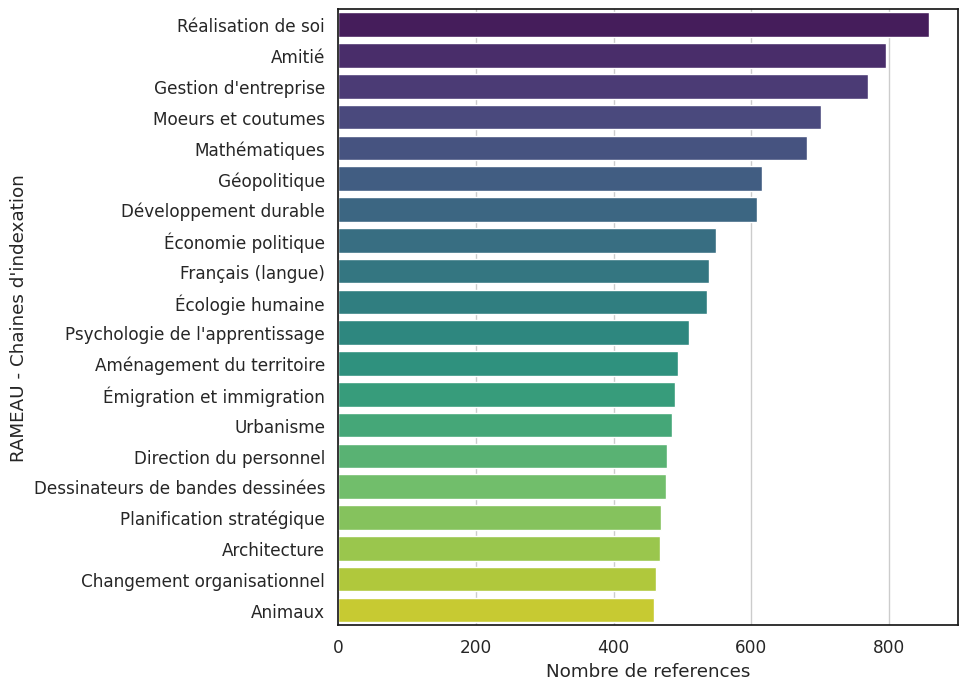

In [76]:
plot_barplot_of_tags(
    tags_list=rameau_list_chaines_index,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Chaines d'indexation",
    figsave=str(filename + "_" + 'barplot_Rameau_ChainesIndex_after_cleaning_cleaned.png'),
    figsize=(8, 8))

### Explore Dewey

In [77]:
if merge_with_dewey:
    # Find DDC domain
    cleaned_df["DDC"] = cleaned_df["DEWEY"].apply(lambda x: get_domain_from_ddc(x))
    # Merge with TEF labels
    ddc = pd.read_csv(os.path.join(data_path, "dewey_label.csv"), index_col=0, dtype=str)

    # Merge 
    cleaned_df = cleaned_df.merge(ddc, on="DDC", how='left')
    print(f"Dimension of the dataframe with TEF labels: {cleaned_df.shape}")
    print("Column headers: ", list(cleaned_df.columns))

    # Visualization
    plot_barplot_of_tags(
        tags_list=cleaned_df["TEF_LABEL"],
        nb_of_tags=20,
        xlabel="Nombre de references",
        ylabel="Libellés TEF",
        figsave='barplot_libelles_TEF.png',
        figsize=(8, 8))

# Save working file as pickle

In [78]:
# Saving file
if working_data_filename.endswith(("pkl", "pickle")):
    cleaned_df.to_pickle(os.path.join(data_path, working_data_filename))
elif working_data_filename.endswith("csv"):
    cleaned_df.to_csv(os.path.join(data_path, working_data_filename))
else: 
    print("saved files must be .csv or .pickle")

In [79]:
## Export data for Lausanne
df_export = cleaned_df.copy()
df_export[["PPN", "TITRE", "RESUME", "RAMEAU_CHECKED"]].to_pickle("export_data_26062023.pkl")
t = pd.read_pickle("export_data_26062023.pkl")
print("Dimension du jeu de données :", t.shape)
t.head(3)

Dimension du jeu de données : (154447, 4)


,PPN,TITRE,RESUME,RAMEAU_CHECKED
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture


# Create train, test and validation datasets

In [80]:
# Define file paths
train_ppn_file = "train_test_valid_sets/training_data.xlsx"
test_ppn_file = "train_test_valid_sets/testing_data.xlsx"
valid_ppn_file_100 = "reindexation_final_juin2023.csv"

In [81]:
# Define train and test sets 
train_set_ppn = pd.read_excel(os.path.join(data_path, train_ppn_file), dtype=str)
print("dimension of train set: ", train_set_ppn.shape)
test_set_ppn = pd.read_excel(os.path.join(data_path, test_ppn_file), dtype=str)
print("dimension of test set: ", test_set_ppn.shape)
valid_set_ppn = pd.read_csv(os.path.join(data_path, valid_ppn_file_100), index_col=0)
print("dimension of validation set: ", valid_set_ppn.shape)

dimension of train set:  (125264, 1)
dimension of test set:  (29244, 1)
dimension of validation set:  (100, 16)


In [82]:
# Reformatage des PPN commencant par des 0
ppn_size = 9
test_set_ppn["PPN"] = test_set_ppn["PPN"].str.zfill(ppn_size)
train_set_ppn["PPN"] = train_set_ppn["PPN"].str.zfill(ppn_size)

In [83]:
# Define sets
df_train = pd.merge(cleaned_df, train_set_ppn, on="PPN", how="inner")
print("dimension of train set: ", df_train.shape)
df_test = pd.merge(cleaned_df, test_set_ppn, on="PPN", how="inner")
print("dimension of test set: ", df_test.shape)
df_valid = pd.merge(cleaned_df, valid_set_ppn["PPN"], on="PPN", how="inner")
print("dimension of test set: ", df_valid.shape)

dimension of train set:  (125220, 10)
dimension of test set:  (29227, 10)
dimension of test set:  (100, 10)


In [39]:
# Save train, test and validation sets en csv
df_train.to_csv(os.path.join(data_path, "train_dataset.csv"), index=0)
df_test.to_csv(os.path.join(data_path, "test_dataset.csv"), index=0)
df_valid.to_csv(os.path.join(data_path, "valid100_dataset.csv"), index=0)

In [40]:
# Save train, test and validation sets en pickle
df_train.to_pickle(os.path.join(data_path, "train_dataset.pkl"))
df_test.to_pickle(os.path.join(data_path, "test_dataset.pkl"))
df_valid.to_pickle(os.path.join(data_path, "valid100_dataset.pkl"))